# Задача

Постараться предсказать стоимость автомобилей из тестовой выборки

## План
1. Загрузить данные из объявлений на auto.ru
2. Разобрать загруженные данные на признаки (парсинг) для тренировочного датасета
3. Сформировать единый датасет из тестовых и тренировочных датасетов
4. Обработать датасет (EDA, Features engenering)
5. Провести обучение
6. Выводы

# 1. Загрузка данных с auto.ru

### Основные принцыпы сбора данных
1. На основе тестового датасета создатим список брендов, моделей, и их число
2. Для каждой из моделей будем пытаться загрузить такое число объявлений, что бы оно было в три раза больше, чем число объявлений в тестовом датасете для такой же модели
3. html-файлы будем сохранять в gzip формате в отдельную директорию

### Код `gets.sh`:
```shell
#!/bin/bash
# в цикле с заданной периодичностью пытается собирать объявления по
# московскому региону, и по всей России

for i in $(seq 22)
do
   echo $i - moskovskaya_oblast start
   python gets.py moskovskaya_oblast
   echo $i - moskovskaya_oblast done - sleep 60
   sleep 60
   echo $i - rossiya start
   python gets.py rossiya
   echo $i - rossiya done - sleep 3600
   sleep 3600
done
```

### Код `gets.py`:
```python
# запуск из shell:
# ./gets.py [регион]
# регион: moskva, moskovskaya_oblast, rossiya и т.д. 

from bs4 import BeautifulSoup
import requests
import json

from datetime import datetime
import time
import os
import sys
import gzip

import pandas as pd
import numpy as np

from tqdm import tqdm

# в директории DATA_DIR будут файлы html запакованные в gzip
DATA_DIR = './html_data'

# если в коммандной строке НЕ передан регион, то по умолчанию moskva
region = 'moskva'
if len(sys.argv)>1:
    region = sys.argv[1]

# в test_models будет таблица от тестового датасета: бренд, модель, число объявлений
test = pd.read_csv('test.csv')
test_models = pd.DataFrame(
    [(brand, model[0], model[1])
     for brand in test.brand.unique()
     for model in test[test.brand==brand].model_name.value_counts().items()],
    columns = ['brand', 'model_name', 'number']
)

# в train_models подобно test_models находятся уже загруженные и обработанные объявления
# они будут нужны для подсчета, сколько нужно еще загрузить объявлений для модели
train = pd.read_csv('train.csv')
train_models = pd.DataFrame(
    [(brand, model[0], model[1])
     for brand in train.brand.unique()
     for model in train[train.brand==brand].model_name.value_counts().items()],
    columns = ['brand', 'model_name', 'number']
)

# функция непосредственно загружает данные по адресу url
# в случае неудачи повторяет попытки до 7 раз
def get_response(url, max_tries=7, sleep_time=15, timeout=(1,5)):
    tries = 0
    while tries < max_tries:
        tries += 1
        try:
            a = requests.adapters.HTTPAdapter(max_retries=1)
            r = requests.Session()
            r.headers.update({'User-Agent': 'Mozilla/5.0'})
            r.mount('http://', a)
            r.mount('https://', a)
            response = r.get(url, timeout=timeout)
            if response.status_code == 200:
                return response
            else:
                print(f'try {tries}, http code: {response.status_code}')
                if tries < max_tries:
                    time.sleep(sleep_time)
                else:
                    raise(requests.exceptions.RequestException(
                        f'http code: {response.status_code}'
                    ))
        except requests.exceptions.RequestException as e:
            print(f'try {tries}', e)
            if tries < max_tries:
                time.sleep(sleep_time)
            else:
                raise(e)

# функция формирует требуемый список ссылок url для конкретной модели
# если на текущей странице объявлений не хватает, то будет переход на слудующую page
def get_urls(brand, model_name, count, region=''):
    # count -- это число объявлений, которое нужно загрузить
    page_url = 'https://auto.ru/{}cars/{}/{}/used/?page={}'.format(
        region + '/' if region else '',
        brand, model_name, '{}'
    )
    urls = set()
    if count < 1:
        return urls

    page_number = 1
    while True:
        url = page_url.format(page_number)
        response = get_response(url)
        page = BeautifulSoup(response.text, 'html.parser')

        # в link_list запишем адреса конкретных объявлений машин
        link_list = page.find_all(
            'a', class_='Link ListingItemTitle-module__link')
        # в price_list запишем цены для машин конкретных объявлений
        price_list = page.find_all(
            class_='ListingItem-module__columnCellPrice')

        # проверим, есть ли у объявления цена и сохраним только объявления
        # с ценами
        for i, link in enumerate(link_list):
            if price_list[i].text == '':
                #print('no price: ' + link['href'])
                pass
            else:
                urls.add(link['href'])
                # если ссылок на объявления достаточно, то возвращяем их
                if len(urls) >= count:
                    return urls

        print(url, len(urls))

        # запишем все имеющиеся page для объявлений данной модели
        p_list = [
            a.text
            for a in page.find_all('a', class_='ListingPagination-module__page')
        ]

        # если page для модели больше нет, то завершаем перебор page
        if not p_list or int(p_list[-1]) <= page_number:
            break
        else:
            page_number += 1

    return urls


# функция сохранения html-страницы объявления в файловую систему
# имя файла -- это sell_id объявления
def save_url_data(url):
    sell_id = url.split('/')[-2].split('-')[0]
    fname = os.path.join(DATA_DIR, f'{sell_id}.html.gz')

    # проверка, что файл для sell_id уже есть
    if os.path.exists(fname):
        return False
    else:
        r = get_response(url)
        r.encoding = 'utf-8'
        with gzip.open(fname, 'wb') as f:
            f.write(r.content)
            return True


# функция для модели формирует список url объявлений и загрузает их
def save_urls(brand, model_name, region, count):
    urls = get_urls(brand, model_name, count, region)
    print('found {} urls ({:.1%})'.format(len(urls), len(urls)/count))
    new_gets = 0
    for url in tqdm(urls):
        new_gets += save_url_data(url)
    print(f'new gets: {new_gets}')


# функция обрабатывает имеющиеся бренды и модели,
# и потом подготавливает входные данные для save_urls
def proc_for_save_urls(test_models, brand, model_list, region, number_mult=3):
    for model_name in model_list:
        number = test_models[
            (test_models.brand == brand) & (test_models.model_name == model_name)
        ].number.iloc[0]
        count_n = number * number_mult
        count = count_n
        count_train = 0
        if True:
            n = train_models[
               (train_models.brand == brand) & (train_models.model_name == model_name)
            ].number
            if len(n):
               count_train = n.iloc[0]
               count -= count_train
        print(f'>>> {region} - {brand} {model_name} - {number} -> {count} ({count_n} - {count_train}) <<<')
        save_urls(brand, model_name, region, count)


# запуск загрузки данных с auto.ru
for brand in test_models.brand.unique():
    model_list = test_models[test_models.brand==brand].model_name.unique()
    proc_for_save_urls(test_models, brand, model_list, region)

```

# 2. Разбор загруженных данных

### Основные принцыпы разбора
1. Прочитать поочередно каждый файл из директории
2. Разобрать его (парсинг)
3. Сохранить результат в датасет

Разбирать из загруженных страниц объявлений буду только следующие признаки:
```python
['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'region']
```
Поскольку тестовый датасет не содержит признак 'region', то по имеющимся в тестовом датасете url загрузил с auto.ru старые объявления и дополнил тестовый датасет регионом. Код не привожу, т.к. он будет идентичен `gets.py` и `make_train.py`.

### Код `make_train.py`:
```python
from bs4 import BeautifulSoup
import requests
import json

from datetime import datetime
import time
import os
import sys
import gzip

import pandas as pd
import numpy as np

from tqdm import tqdm


# функция читает и парсит файл
def parse_file(sell_id):
    fname = os.path.join(DATA_DIR, f'{sell_id}.html.gz')
    with gzip.open(fname, 'rb') as f:
        btext = f.read()
    parse_utime = int(os.path.getmtime(fname))

    try:
        page = BeautifulSoup(btext, 'html.parser')
        js = json.loads(page.select_one(
            "script", type="application/ld+json").string)
        js2 = json.loads(page.find_all(
            "script", type="application/json", id="initial-state")[0].string)

        return True, {
            'sell_id': sell_id,
            'parsing_unixtime': parse_utime,
            'car_url': js['offers']['url'],
            'region': js2['card']['seller']['location']['region_info']['name'],
            'region_latitude': js2['card']['seller']['location']['region_info']['latitude'],
            'region_longitude': js2['card']['seller']['location']['region_info']['longitude'],
            'bodyType': js['bodyType'],
            'brand': js['brand'],

            'model_name': js2['card']['vehicle_info']['model_info']['code'],

            'color': js['color'],
            'engineDisplacement': js['vehicleEngine']['engineDisplacement'],
            'enginePower': js['vehicleEngine']['enginePower'],
            'fuelType': js['vehicleEngine']['fuelType'],
            'modelDate': js['modelDate'],
            'numberOfDoors': js['numberOfDoors'],
            'productionDate': js['productionDate'],
            'vehicleTransmission': js['vehicleTransmission'],

            'mileage': js2['card']['state']['mileage'],
            'vendor': js2['card']['vehicle_info']['vendor'],

            'Владельцы': page.find(class_="CardInfoRow_ownersCount").find_all("span")[1].text,
            'ПТС': page.find(class_="CardInfoRow_pts").find_all("span")[1].text,
            'Привод': page.find(class_="CardInfoRow_drive").find_all("span")[1].text,
            'Руль': page.find(class_="CardInfoRow_wheel").find_all("span")[1].text,
            'Состояние': page.find(class_="CardInfoRow_state").find_all("span")[1].text,
            'Таможня': page.find(class_="CardInfoRow_customs").find_all("span")[1].text,

            'price': js['offers']['price'],
        }
    except (KeyError, AttributeError) as e:
        return False, e


DATA_DIR = './html_data'
TRAIN = 'train.csv'

# в output будет тренировочный датасет
output = pd.DataFrame()

# если файл с тестовым датасетом уже есть, то используем его,
# что бы повторно не разбирать скаченные html-файлы
if os.path.exists(TRAIN):
    output = pd.read_csv(TRAIN)

# check_list содержит уже разобранные объявления (sell_id)
check_list = output.sell_id.astype('int64').values if not output.empty else []

new_saves = 0
for dirpath, _, filenames in os.walk(DATA_DIR):
    for f in tqdm(filenames):
        sell_id = f.split('.')[0]
        # если sell_id уже разобран, то не обрабатываем файл
        if int(sell_id) in check_list:
            continue
        s, data = parse_file(sell_id)
        # если обработка прошла неуспешно, то файл удаляем
        if not s:
            fname = os.path.join(DATA_DIR, f)
            print(fname, type(data), data)
            os.remove(fname)
            print(f'{fname} deleted')
        else:
            output = output.append(data, ignore_index=True)
            new_saves += 1
            if not len(output) % 100:
                output.to_csv(TRAIN, index=False)

if new_saves:
    output.to_csv(TRAIN, index=False)

print(f'New cars saved: {new_saves}')
print('Total cars: {}'.format(output.shape[0]))
```

# 3. Сформировать единый датасет

In [1]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor

from xgboost import XGBRegressor

from catboost import CatBoostRegressor

In [2]:
# расчет выбросов
def outliers_iqr(x):
    quartile_1, quartile_3 = np.percentile(x, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)    
    return np.where((x > upper_bound) | (x < lower_bound))[0]

In [3]:
# Сделаем класс, который будет, как читать данные и собирать единый датасет,
# так и обрабатывать признаки

CURRENT_YEAR = 2021  # текущий год для расчета возраста машины

class Cars():
    ################################################################
    # Функции чтения и объединения тестовых и тренировочных данных

    def read_test(self, fname='test.csv'):
        # читаем тестовый датасет
        self.test = pd.read_csv(fname)

    def read_test_geo(self, fname='test_geo.csv'):
        # читаем дополнительные данные для тестового датасета,
        # а именно, регион, в котором продавалась машина
        self.test_geo = pd.read_csv(fname)

    def read_train(self, fname='train.csv'):
        # читаем тренировочный датасет
        self.train = pd.read_csv(fname)

    def read_sample_submission(self, fname='sample_submission.csv'):
        # читаем список sell_id тестовой выборки для передачи на kaggle
        self.sample_submission = pd.read_csv(fname)

    def print_stat(self):
        # печатаем размеры датасетов
        print('Test:', self.test.shape[0])
        print('Train:', self.train.shape[0])
        print(
            'Train/Test:',
            round(self.train.shape[0]/self.test.shape[0], 2)
        )

    def delete_duplicates(self):
        # удалим из тренировочных данных машины, которые так же есть в тестовых данных
        self.train.drop(
            self.train[
                self.train.sell_id.isin(self.test.sell_id)
            ].index,
            inplace=True
        )

    def float64_to_int64(self):
        # в train переводим все float64 в int64
        for col in filter(
            lambda col: self.train.dtypes[col] == np.float64,
            self.train.columns
        ):
            self.train[col] = self.train[col].astype('int64')

        # в test_geo.sell_id переводим в int64
        self.test_geo.sell_id = self.test_geo.sell_id.astype('int64')

    def fix_test_geo(self):
        # добавляем регион из test_geo в test
        # если гео-данных нет, то 'определяем' в Москву
        if 'region' not in self.test.columns:
            self.test = pd.merge(self.test, self.test_geo,
                                 on=['sell_id'], how='left')
            self.test.region.fillna('Москва', inplace=True)

    def make_one_dataset(self):
        # создаем один датасет из тестовых и тренировочных данных
        self.delete_duplicates()
        self.float64_to_int64()
        self.fix_test_geo()
        self.print_stat()

        # интересующие числовые признаки из обоих датасетов
        self.col_num = [
            'engineDisplacement',
            'enginePower',
            'mileage',
            'modelDate',
            'numberOfDoors',
            'productionDate',
        ]
        # интересующие катигориальные признаки из обоих датасетов
        self.col_cats = [
            'bodyType',
            'brand',
            'color',
            'fuelType',
            'model_name',
            'vehicleTransmission',
            'vendor',
            'Владельцы',
            'ПТС',
            'Привод',
            'Руль',
            'region',
        ]

        # колонки для dummies для бинарных
        self.col_cats_dummies_bin = []

        # колонки с категориями, переведенные в коды через LabelEncoder
        self.col_cats_codes = []

        # добавим пустой прайс в test
        self.test['price'] = np.NaN

        # представляющие интерес колонки для объединения в один датасет
        col_interest = ['sell_id', 'price', 'Train'] + \
            self.col_num + self.col_cats

        # Объединяем все в один датасет
        self.train['Train'] = 1
        self.test['Train'] = 0
        self.data = self.train[col_interest].append(
            self.test[col_interest],
            sort=False
        ).reset_index(drop=True)

    def read_all(self):
        # читаем все данные
        self.read_test()
        self.read_test_geo()
        self.read_train()
        self.read_sample_submission()

    ################################################################
    # Функции обработки числовых колонок

    def proc_target(self):
        # прологорифмируем цену, т.к. в этом виде она хорошо выглядит
        self.data['price_log'] = np.log(self.data.price)

    def proc_engineDisplacement(self):
        # Почистим engineDisplacement от букв, оставив только числа
        self.data['ed'] = self.data.apply(
            # электро-машины будут с нулевым объемом двигателя
            lambda raw: 0 if raw.fuelType == 'электро' \
            else np.float64(raw.engineDisplacement.split(' ')[0]),
            axis=1
        )

        # добавляем ed в список числовых, и удаляем engineDisplacement из списка числовых
        self.col_num += [] if 'ed' in self.col_num else ['ed']
        self.col_num = list(set(self.col_num) - set(['engineDisplacement']))

    def proc_enginePower(self):
        # Почистим enginePower от букв, оставив только числа
        # и прологорифмируем, т.к. в этом виде она хорошо выглядит
        self.data['ep_log'] = np.log(
            self.data.enginePower.apply(
                lambda ep: int(ep.split(' ')[0])
            )
        )

        # добавляем ep_log в список числовых и удаляем ep и enginePower из этого списка
        self.col_num += [] if 'ep_log' in self.col_cats else ['ep_log']
        self.col_num = list(set(self.col_num) - set(['enginePower']))

    def proc_Date(self):
        # добавми так же новый признак -- возраст машины
        self.data['car_age'] = np.full(
            self.data.shape[0], CURRENT_YEAR
        ) - self.data.productionDate

        # добавляем car_age в список числовых, и удаляем productionDate из него
        self.col_num += [] if 'car_age' in self.col_cats else ['car_age']
        self.col_num = list(set(self.col_num) - set(['productionDate']))

    def proc_mileage(self):
        # имеет смысл использовать логорифм для mileage
        self.data['mileage_log'] = np.log(self.data.mileage)

        # добавляем mileage_log в список числовых, и удаляем mileage из него
        self.col_num += [] if 'mileage_log' in self.col_cats else ['mileage_log']
        self.col_num = list(set(self.col_num) - set(['mileage']))

    def proc_numbers(self):
        # все преобразования с числовыми сразу
        self.proc_engineDisplacement()
        self.proc_enginePower()
        self.proc_Date()
        self.proc_mileage()

    ################################################################
    # Функции обработки категориальных колонок

    def proc_cats_fill_na(self):
        # заполним пустые поля cat-признаков наиболее встречающимся значением
        for col in self.col_cats:
            self.data[col].fillna(
                self.data[col].mode()[0],
                inplace=True
            )

    def proc_cats(self):
        # все преобразования с категориальными сразу
        self.proc_cats_fill_na()

    ################################################################
    # Функции преобразования категориальных признаков в числа

    def make_dummies(self):
        # создаем новые признаки через get_dummies для бинарных категорий
        data_dummies = pd.get_dummies(self.data[
            list(filter(
                lambda col: self.data[col].nunique() == 2,
                self.col_cats
            ))
        ])
        # для бинарных название колонок будет с префиксом bin_
        prefix = 'bin_'
        for col in data_dummies.columns:
            if col in self.data.columns:
                self.data.drop(col, axis=1, inplace=True)
            self.data = self.data.join(
                data_dummies[[col]].rename(
                    lambda col: f'{prefix}{col}', axis='columns')
            )
        self.col_cats_dummies_bin = list(map(
            lambda col: f'{prefix}{col}',
            data_dummies.columns.to_list()
        ))

    def make_codes(self):
        # для категориальных с большим, чем 2, значениями категорий
        # преобразуем в числа через LabelEncoder
        label_encoder = LabelEncoder()
        self.col_cats_codes = []
        for col in filter(
            lambda col: self.data[col].nunique() > 2,
            self.col_cats
        ):
            code_col = f'code_{col}'
            self.col_cats_codes += [code_col, ]
            self.data[code_col] = label_encoder.fit_transform(
                self.data[col]
            )

### Чтение данных

In [4]:
cars = Cars()
cars.read_all()

### Формирование одного датасета из тестовых и тренировочных данных

In [5]:
cars.make_one_dataset()

Test: 34686
Train: 94390
Train/Test: 2.72


# 4. Обработка датасета

In [6]:
# в cars.data объединенный датасет
cars.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129076 entries, 0 to 129075
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sell_id              129076 non-null  int64  
 1   price                94390 non-null   float64
 2   Train                129076 non-null  int64  
 3   engineDisplacement   129076 non-null  object 
 4   enginePower          129076 non-null  object 
 5   mileage              129076 non-null  int64  
 6   modelDate            129076 non-null  int64  
 7   numberOfDoors        129076 non-null  int64  
 8   productionDate       129076 non-null  int64  
 9   bodyType             129076 non-null  object 
 10  brand                129076 non-null  object 
 11  color                129076 non-null  object 
 12  fuelType             129076 non-null  object 
 13  model_name           129076 non-null  object 
 14  vehicleTransmission  129076 non-null  object 
 15  vendor           

In [7]:
cars.data.iloc[0]

sell_id                   1102202395
price                       280000.0
Train                              1
engineDisplacement           2.0 LTR
enginePower                  180 N12
mileage                       300000
modelDate                       1993
numberOfDoors                      4
productionDate                  1994
bodyType               седан-хардтоп
brand                         TOYOTA
color                        зелёный
fuelType                      бензин
model_name               CORONA_EXIV
vehicleTransmission     механическая
vendor                      JAPANESE
Владельцы                3 или более
ПТС                         Оригинал
Привод                      передний
Руль                          Правый
region                      Владимир
Name: 0, dtype: object

In [8]:
# числовые и категориальные признаки
print(f'Num: {cars.col_num}')
print()
print(f'Cat: {cars.col_cats}')

Num: ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate']

Cat: ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'region']


### Целевая переменная price

<AxesSubplot:>

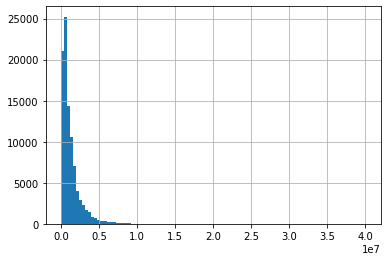

In [9]:
# Посмотрим на целевую переменную
cars.data.price.hist(bins=100)

<AxesSubplot:>

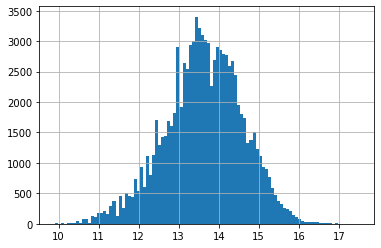

In [10]:
np.log(cars.data.price).hist(bins=100)

In [11]:
# после логорифмирования смотриться лучше, сделаем целевую переменную в логорифме
cars.proc_target()

## Обработка числовых признаков

In [12]:
cars.col_num

['engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'numberOfDoors',
 'productionDate']

### engineDisplacement

In [13]:
cars.data.engineDisplacement.unique()[::10], \
cars.data.engineDisplacement.nunique()

(array(['2.0 LTR', '3.7 LTR', '5.8 LTR', '0.7 LTR', '3.1 LTR', '3.8 LTR'],
       dtype=object),
 56)

In [14]:
# избавимся от букв, оставив только числа
cars.proc_engineDisplacement()

### enginePower

In [15]:
cars.data.enginePower.unique()[::10], \
cars.data.enginePower.nunique()

(array(['180 N12', '105 N12', '181 N12', '131 N12', '194 N12', '218 N12',
        '258 N12', '101 N12', '185 N12', '585 N12', '188 N12', '69 N12',
        '372 N12', '380 N12', '103 N12', '80 N12', '133 N12', '233 N12',
        '394 N12', '78 N12', '317 N12', '281 N12', '520 N12', '241 N12',
        '183 N12', '507 N12', '214 N12', '580 N12', '522 N12', '321 N12',
        '93 N12', '153 N12', '138 N12', '626 N12'], dtype=object),
 337)

<AxesSubplot:>

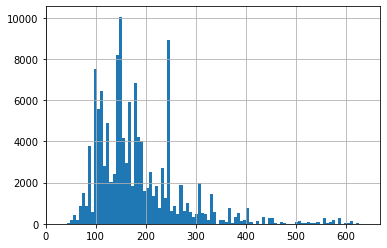

In [16]:
cars.data.enginePower.apply(
    lambda ep: int(ep.split(' ')[0])
).hist(bins=100)

<AxesSubplot:>

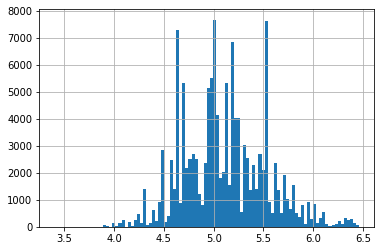

In [17]:
# избавимся от букв, оставив только числа, и прологорифмируем
cars.proc_enginePower()
cars.data.ep_log.hist(bins=100)

### modelDate и productionDate

In [18]:
# modelDate оставим, как есть, а productionDate переведем в возраст машины
cars.proc_Date()

<AxesSubplot:xlabel='car_age'>

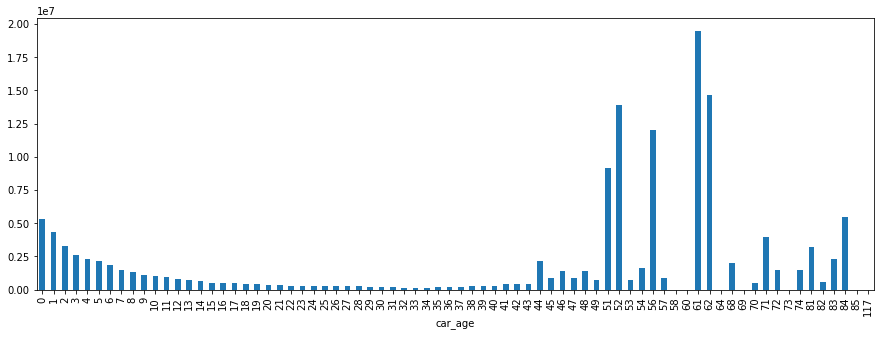

In [19]:
# Видно, что чем старше машина, тем она дешевле стоит
# Но есть раритетные модели (за 40), которые стоят очень много
cars.data.groupby('car_age').price.mean(). \
plot(kind = 'bar', figsize=(15,5))

### mileage

<AxesSubplot:>

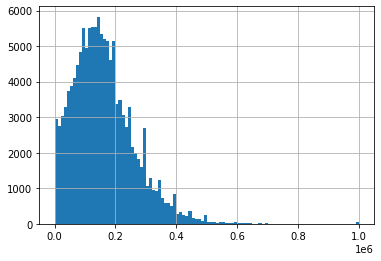

In [20]:
cars.data.mileage.hist(bins=100)

<AxesSubplot:>

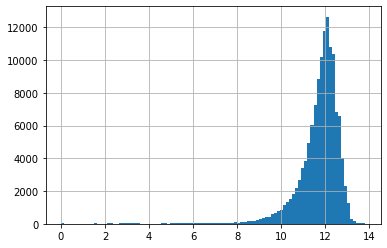

In [21]:
# Кажется, что в логорифме mileage будет лучше
cars.proc_mileage()
cars.data.mileage_log.hist(bins=100)

<AxesSubplot:xlabel='mileage'>

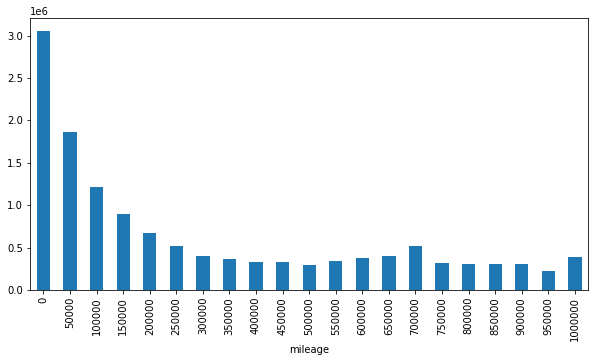

In [22]:
# так же очевидно, что цена тем выше (в среднем), чем меньше пробег у машины
cars.data.groupby(
    cars.data.mileage.map(
        lambda m: m // 50000 * 50000
    )
).price.mean().plot(kind = 'bar', figsize=(10,5))

In [23]:
cars.data[cars.col_num].head()

,ed,mileage_log,modelDate,car_age,numberOfDoors,ep_log
0,2.0,12.611538,1993,27,4,5.192957
1,1.6,10.638256,2014,4,5,4.736198
2,3.0,11.309437,2015,6,5,5.517453
3,1.4,10.940224,2010,7,4,4.804021
4,2.0,12.192121,2005,15,4,5.043425


### Выбросы

In [24]:
print('Выбросы в тестовом датасете')
for col in cars.col_num:
    print(col, len(outliers_iqr(cars.data[cars.data.Train==0][col])))
print()
print('Выбросы в тренеровочном датасете')
for col in cars.col_num:
    print(col, len(outliers_iqr(cars.data[cars.data.Train==1][col])))

Выбросы в тестовом датасете
ed 1041
mileage_log 1808
modelDate 1562
car_age 1236
numberOfDoors 1207
ep_log 98

Выбросы в тренеровочном датасете
ed 2103
mileage_log 4786
modelDate 3645
car_age 3132
numberOfDoors 2529
ep_log 880


In [25]:
# Выбросы есть, но они есть и в тестовом датасете. Убирать их не буду.

## Обработка категориальных признаков

In [26]:
# для всех категориальных признкаов заполним пропуски наиболее встречающимся значением
cars.proc_cats()

In [27]:
cars.data[cars.col_cats].head(3)

,bodyType,brand,color,fuelType,model_name,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,region
0,седан-хардтоп,TOYOTA,зелёный,бензин,CORONA_EXIV,механическая,JAPANESE,3 или более,Оригинал,передний,Правый,Владимир
1,внедорожник 5 дв.,NISSAN,серый,бензин,TERRANO,механическая,JAPANESE,1 владелец,Оригинал,передний,Левый,Москва
2,внедорожник 5 дв.,AUDI,серый,дизель,Q7,автоматическая,EUROPEAN,2 владельца,Оригинал,полный,Левый,Москва


In [28]:
# посмотрим на значения категориальных признаков
for col in reversed(sorted(cars.col_cats,
                           key=lambda c: cars.data[c].nunique())):
    print(f'{col}: {cars.data[col].nunique()}')
    if cars.data[col].nunique() > 15:
        print(cars.data[col].unique()[:10])
    else:
        print(cars.data[col].unique())
    print("")

region: 2781
['Владимир' 'Москва' 'Егорьевск' 'Санкт-Петербург' 'Раздоры'
 'Наро-Фоминск' 'Рязань' 'Отрадное' 'Химки' 'Люберцы']

model_name: 544
['CORONA_EXIV' 'TERRANO' 'Q7' 'JETTA' 'ACCORD' 'QASHQAI' '5ER' 'GOLF' 'A6'
 'A3']

bodyType: 24
['седан-хардтоп' 'внедорожник 5 дв.' 'седан' 'хэтчбек 5 дв.' 'лифтбек'
 'универсал 5 дв.' 'купе' 'пикап двойная кабина' 'купе-хардтоп' 'минивэн']

color: 16
['зелёный' 'серый' 'чёрный' 'синий' 'серебристый' 'красный' 'белый'
 'коричневый' 'золотистый' 'голубой']

brand: 12
['TOYOTA' 'NISSAN' 'AUDI' 'VOLKSWAGEN' 'HONDA' 'BMW' 'MITSUBISHI' 'SKODA'
 'VOLVO' 'MERCEDES' 'INFINITI' 'LEXUS']

fuelType: 5
['бензин' 'дизель' 'гибрид' 'электро' 'газ']

vehicleTransmission: 4
['механическая' 'автоматическая' 'роботизированная' 'вариатор']

Привод: 3
['передний' 'полный' 'задний']

Владельцы: 3
['3 или более' '1\xa0владелец' '2\xa0владельца']

Руль: 2
['Правый' 'Левый']

ПТС: 2
['Оригинал' 'Дубликат']

vendor: 2
['JAPANESE' 'EUROPEAN']



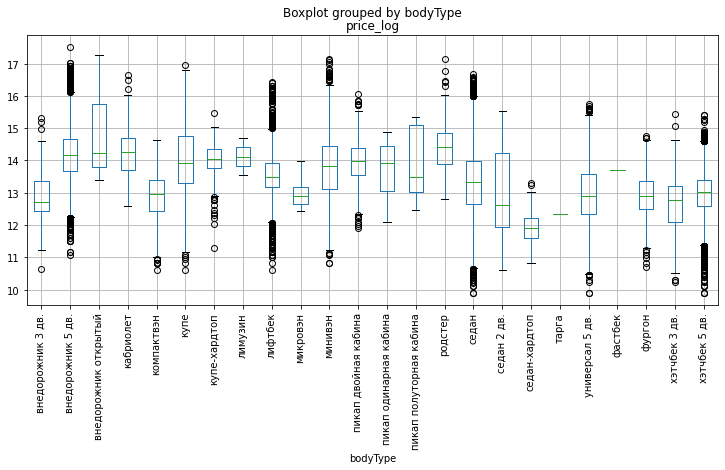

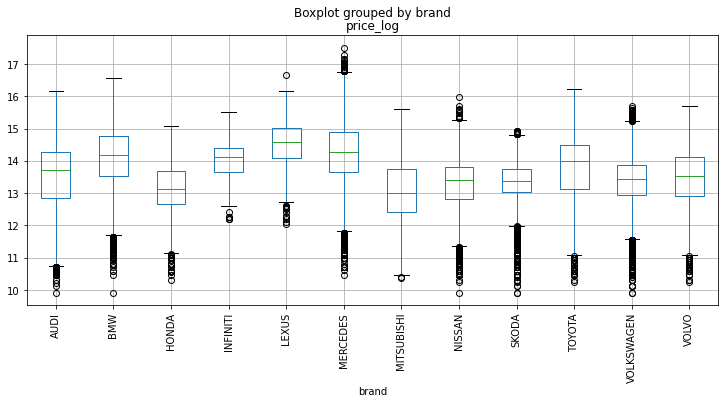

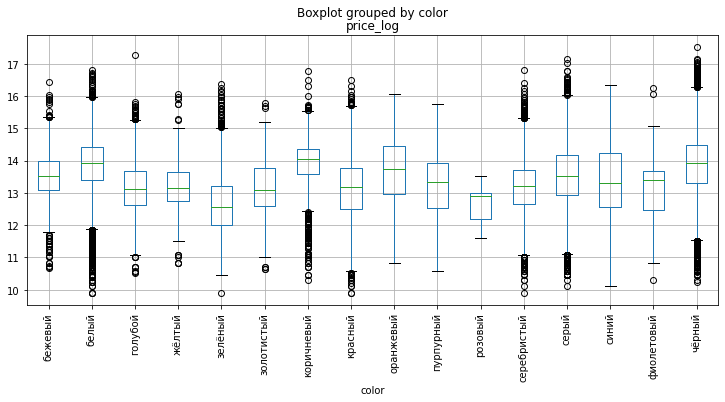

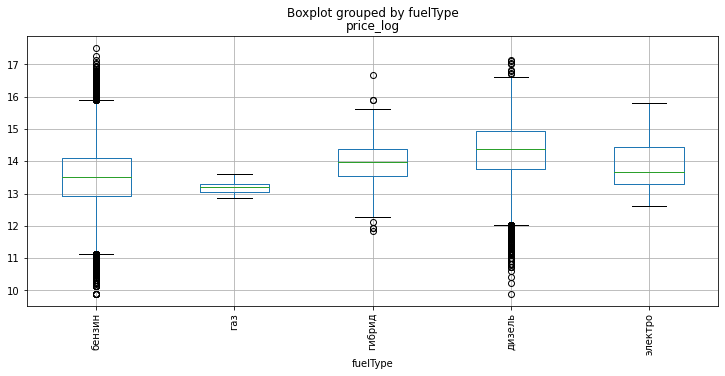

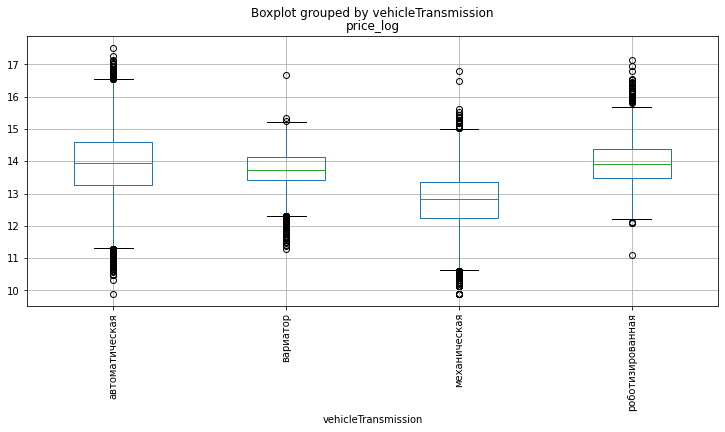

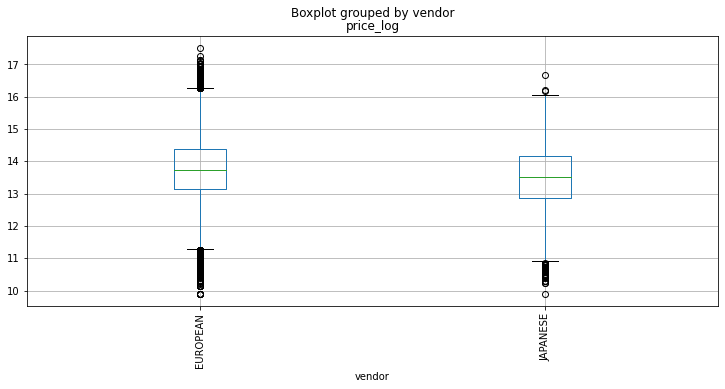

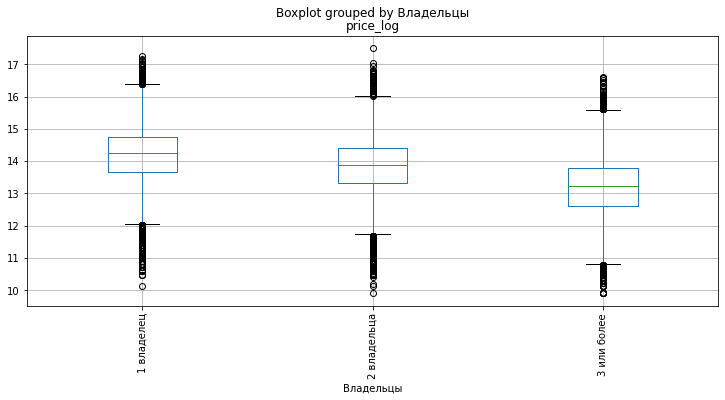

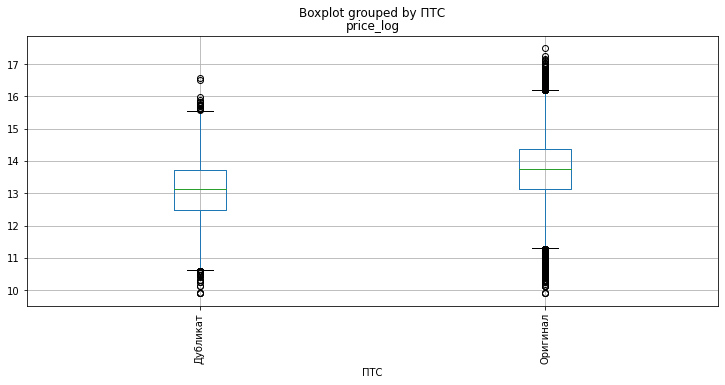

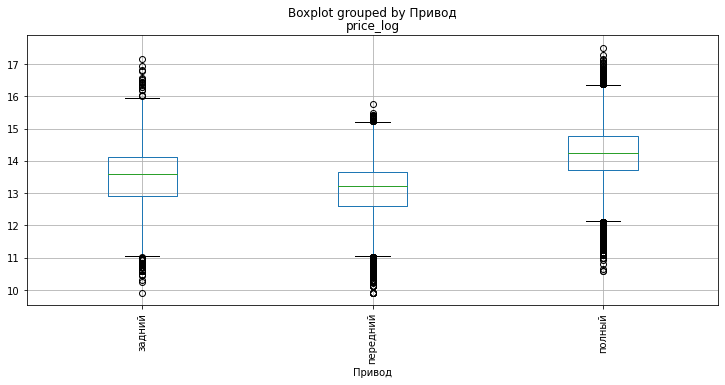

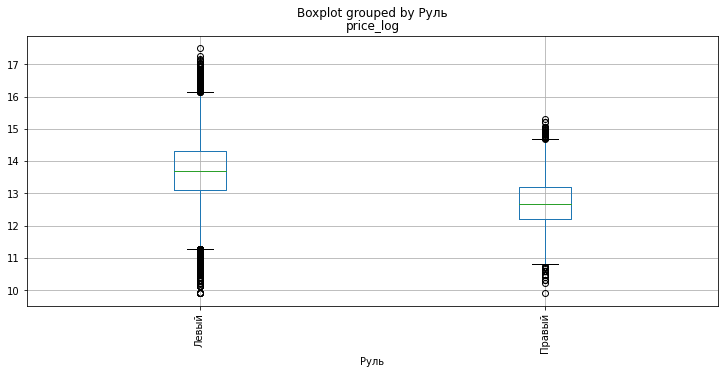

In [29]:
# посмотрим на зависимость цены от значении разных категориальных признаков
# (для тех, у которых категорий меньше 25)
for col in filter(
    lambda c: cars.data[c].nunique()<25,
    cars.col_cats
):
    cars.data.boxplot('price_log', by=col, rot=90, figsize=(12,5))

In [30]:
# Зависимости наблюдаются, но что-то определенно выдающееся выделить сложно.
# Оставляем все, как есть.

### Преобразование бинарных категорий

In [31]:
# Для бинарных категорий сделаем dummies преобразование
cars.make_dummies()

In [32]:
cars.data[cars.col_cats_dummies_bin].head(3)

,bin_vendor_EUROPEAN,bin_vendor_JAPANESE,bin_ПТС_Дубликат,bin_ПТС_Оригинал,bin_Руль_Левый,bin_Руль_Правый
0,0,1,0,1,0,1
1,0,1,0,1,1,0
2,1,0,0,1,1,0


### Преобразование небинарных категорий

In [33]:
# Для остальных сделаем просто кодирование
cars.make_codes()

In [34]:
cars.data[cars.col_cats_codes].head(3)

,code_bodyType,code_brand,code_color,code_fuelType,code_model_name,code_vehicleTransmission,code_Владельцы,code_Привод,code_region
0,17,9,4,0,130,2,2,1,411
1,1,7,12,0,462,2,0,1,1473
2,1,0,12,3,366,0,1,2,1473


## Оценка значимости признаков

In [35]:
# Разбиваем общий датасет обратно на тестовый и тренировочный
df_train = cars.data[cars.data.Train==1]
df_test = cars.data[cars.data.Train==0]

Text(0.5, 0, 'F-value')

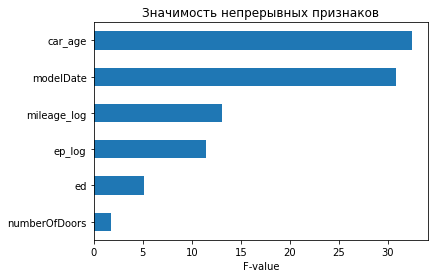

In [36]:
# Значимость непрерывных признаков
imp_num = Series(f_classif(df_train[cars.col_num],df_train['price'])[0],
                 index=cars.col_num)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных признаков')
plt.xlabel('F-value')

<AxesSubplot:>

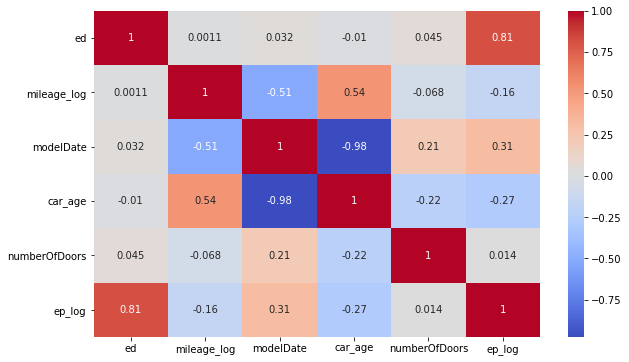

In [37]:
# Посмотрим корреляцию числовых признаков
plt.figure(figsize=(10, 6))
sns.heatmap(cars.data[cars.col_num].corr(), annot=True, cmap='coolwarm')

In [38]:
# Очень сильная зависимость между modelDate (год выпуска модели) и car_age (возраст машины),
# что, в принципе, очевидно.
# И сильная зависимость между литражем и мощностью
# Но избавимся только от modelDate
cars.col_num = list(set(cars.col_num) - set(['modelDate']))
cars.col_num

['ed', 'mileage_log', 'car_age', 'numberOfDoors', 'ep_log']

Text(0.5, 1.0, 'Значимость бинарных признаков')

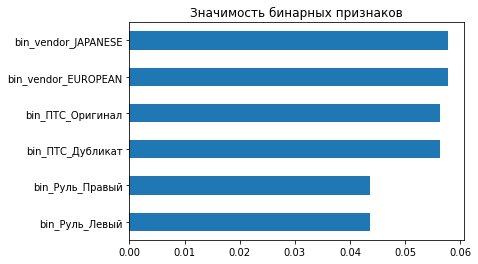

In [39]:
# Значимость бинарных признаков
imp_bin = Series(mutual_info_classif(df_train[cars.col_cats_dummies_bin],
                                     df_train['price'],
                                     discrete_features=True),
                 index=cars.col_cats_dummies_bin)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

Text(0.5, 1.0, 'Значимость категорисльных признаков')

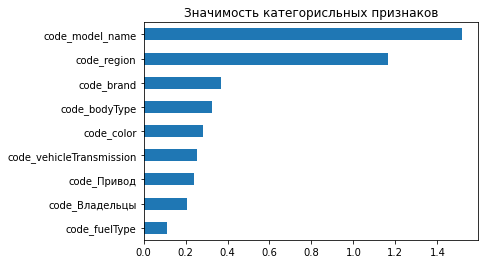

In [40]:
# Значимость категориальных признаков
imp_cat = pd.Series(mutual_info_classif(df_train[cars.col_cats_codes],
                                        df_train['price'],
                                        discrete_features=True),
                    index=cars.col_cats_codes)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категорисльных признаков')

In [42]:
# Категориальные признаки оставляем, как есть

# 5. Провести обучение

## Подготовка данных к обучению

In [43]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(df_train[cars.col_num].values)
X_num_test = StandardScaler().fit_transform(df_test[cars.col_num].values)

# Объединим все в одно пространство
X = np.hstack([
    X_num_train,
    df_train[cars.col_cats_dummies_bin].values,
    df_train[cars.col_cats_codes].values,
])
y = df_train['price_log'].values

X_ids_test = np.hstack([
    X_num_test,
    df_test[cars.col_cats_dummies_bin].values,
    df_test[cars.col_cats_codes].values,
])
ids_test = df_test['sell_id']

RANDOM_SEED = 42
VAL_SIZE   = 0.20   # 20%

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE,
    shuffle=True, random_state=RANDOM_SEED)

## Обучение

In [44]:
# расчет метрики MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Печать результата модели
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print('Точность по метрике MAPE:', round((mape(y_test, y_pred))*100, 2))

### Модель 0. CatBoostRegressor

In [45]:
start = datetime.now()

cat_br = CatBoostRegressor(iterations = 50,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
cat_br.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True,
         verbose=False,
         plot=True
         )

predict = cat_br.predict(X_test)
print_learn_report(start, y_test, predict)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Время выполнения -  0:00:01.552240
Точность по метрике MAPE: 1.13


###  Модель 1. RandomForestRegressor

In [46]:
start = datetime.now()

rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

rfr.fit(X_train, y_train)

predict = rfr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:05.073740
Точность по метрике MAPE: 1.02


In [47]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

##### Подбор RandomForestRegressor

In [48]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=4)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [6, 9, 12, 15, None],
}

rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                               n_iter=40, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
rfr_random.fit(X_train, np.log(y_train))
rfr_random.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 15}

In [49]:
np.round(rfr_random.best_score_, 2)

0.95

In [56]:
rfr_random_best_params = {
    'n_estimators': 400, 
    'max_features': 'auto', 
    'max_depth': 15,
}

In [57]:
start = datetime.now()

best_rfr = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    **rfr_random_best_params,
)

best_rfr.fit(X_train, y_train)

predict = best_rfr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:13.742151
Точность по метрике MAPE: 1.01


##### Бэггинг для RandomForestRegressor

In [58]:
start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)

bagg_rfr.fit(X_train, y_train)

predict = bagg_rfr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:42.715503
Точность по метрике MAPE: 1.02


###  Модель 2. GradientBoostingRegressor

In [59]:
start = datetime.now()

gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)

predict = gbr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:13.284890
Точность по метрике MAPE: 1.28


In [60]:
gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### Подбор GradientBoostingRegressor

In [61]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=400, num=8)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator=gbr, param_distributions=random_grid,
                                n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)

gbr_random.fit(X_train, np.log(y_train))
gbr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 7}

In [62]:
np.round(gbr_random.best_score_, 2)

0.95

In [63]:
gbr_random_best_params = {
    'n_estimators': 400,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'max_depth': 7
}

In [64]:
start = datetime.now()

best_gbr = GradientBoostingRegressor()
best_gbr.get_params(gbr_random_best_params)

best_gbr.fit(X_train, y_train)

predict = best_gbr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:13.266396
Точность по метрике MAPE: 1.28


##### Бэггинг для GradientBoostingRegressor

In [65]:
start = datetime.now()

bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

bagg_gbr.fit(X_train, y_train)

predict = bagg_gbr.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:24.321998
Точность по метрике MAPE: 1.28


###  Модель 3. XGBRegressor

In [66]:
start = datetime.now()

xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                   learning_rate=0.05, max_depth=12, alpha=1,
                   n_estimators=1000)

xgb.fit(X_train, y_train)

predict = xgb.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:46.489685
Точность по метрике MAPE: 0.96


##### Подбор XGBRegressor

In [ ]:
parametres = {
    'nthread': [12],  # when use hyperthread, xgboost may become slower
    'objective': ['reg:linear', 'reg:squarederror'],
    'learning_rate': [.03, .05, .07],  # so called `eta` value
    'max_depth': [int(x) for x in np.linspace(5, 15, num=6)],
    'min_child_weight': [4],
    'subsample': [0.7],
    'colsample_bytree': [0.5],
    'colsample_bytree': [0.5, 0.7],
    'alpha': [1],
    'n_estimators': [1000]
}

xgb = XGBRegressor()
xgb_random = GridSearchCV(xgb, parametres,
                          cv=3, verbose=10, n_jobs=-1)

xgb_random.fit(X_train, np.log(y_train))
xgb_random.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [77]:
xgb_random_best_params = {
    'alpha': 1,
    'colsample_bytree': 0.5,
    'learning_rate': 0.07,
    'max_depth': 15,
    'min_child_weight': 4,
    'n_estimators': 1000,
    'nthread': 12,
    'objective': 'reg:squarederror', # reg:linear is now deprecated
    'subsample': 0.7
}

In [ ]:
np.round(xgb_random.best_score_, 2)

In [211]:
start = datetime.now()

best_xgb = XGBRegressor()
best_xgb.get_params(xgb_random_best_params)

best_xgb.fit(X_train, y_train)

predict = best_xgb.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:00:02.337592
Точность по метрике MAPE: 15.73


##### Бэггинг для XGBRegressor

In [31]:
start = datetime.now()

bagg_xgb = BaggingRegressor(best_xgb_reg, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)

bagg_xgb.fit(X_train, y_train)

predict = bagg_xgb.predict(X_test)
print_learn_report(start, y_test, predict)

/home/revyakin/jupyter/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



Время выполнения -  0:02:09.339902
Точность по метрике MAPE: 0.94


## Стеккинг

In [ ]:
# Три модели с ансамбле
# - RandomForestRegressor
# - GradientBoostingRegressor
# - XGBRegressor
estimators = [
    ('b_rfr', BaggingRegressor(
        RandomForestRegressor(
            random_state=RANDOM_SEED,
            **rfr_random_best_params,
        ),
        n_estimators=3,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )),
    ('b_gbr', BaggingRegressor(
        GradientBoostingRegressor(
            random_state=RANDOM_SEED,
            **gbr_random_best_params,
        ),
        n_estimators=3,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )),
    ('b_xgb', XGBRegressor(
        **xgb_random_best_params
    ))
]

In [32]:
estimators = [
    ('rfr', rfr),
    ('xgb', xgb)
]

In [33]:
start = datetime.now()

# завершающий - CatBoostRegressor
st_ensemble = StackingRegressor(
    estimators=estimators,
    final_estimator = CatBoostRegressor(
        iterations = 500,
        random_seed = RANDOM_SEED,
        eval_metric='MAPE',
        custom_metric=['R2', 'MAE'],
        silent=True,
        learning_rate=0.13,
        depth=12,
        l2_leaf_reg=8,
        random_strength=0.3
    )
)

st_ensemble.fit(X_train, y_train)

predict = st_ensemble.predict(X_test)
print_learn_report(start, y_test, predict)


Время выполнения -  0:08:32.967451
Точность по метрике MAPE: 0.95


### Submission

In [ ]:
predict = np.int64(np.exp(
    st_ensemble.predict(X_ids_test)
))

In [39]:
cars.sample_submission.price = predict

In [40]:
cars.sample_submission.to_csv('submission.csv', index=False)

# 6. Выводы
1. С auto.ru загружено около 95 тыс. объявлений
2. Определены признаки, подходящие для тествого и для тренировочного датасетов
3. Проведены анализ признаков, оценка их значимости и скоррелированности
4. Созданы несколько новых признаков и сделан набор данных для работы с алгоритмами
5. Протестировано 4 алгоритма с беггингом и ансамблем
6. Полученный результат на Каггле: 16.65

Возможно, для улучшения результата можно было:
1. собрать больше тренировочных данных с auto.ru
2. разобрать больше признаков в html, что бы соотнести их с неиспользуемыми мной колонками в тестовом датасете, такими как: `complectation_dict, description, equipment_dict, vehicleConfiguration`
3. создать новые признаки на основе дополнительных данных